In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import requests

from scipy import sparse
import scipy.stats as sps

### Задание 1
Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). 

In [2]:
YEAR_TRAIN, YEAR_TEST = 2019, 2020
RANDOM_STATE = 42

In [12]:
with open('chgk/players.pkl', 'rb') as file:
    players = pickle.load(file)
with open('chgk/results.pkl', 'rb') as file:
    results = pickle.load(file)
with open('chgk/tournaments.pkl', 'rb') as file:
    tournaments = pickle.load(file)
with open('positions.pickle', 'rb') as file:
    positions = pickle.load(file)

In [4]:
df_tournaments = pd.DataFrame.from_dict(tournaments, orient='index')

In [5]:
df_players = pd.DataFrame.from_dict(players, orient='index')

In [8]:
dates =[]
players = {}

q_id = 0
for t_id in tqdm(df_tournaments.sort_values('dateStart').id): #отсортированый порядок для того чтобы запомнить последний рейтинг
    if not results[t_id]:
        continue
    year = int(tournaments[t_id]['dateStart'][:4])
    if year in [YEAR_TRAIN, YEAR_TEST]:
        for team in results[t_id]:
            if team.get('mask') and (('?' not in team['mask']) and ('X' not in team['mask'])):
                for i, m in enumerate(team['mask']):
                    for member in team['teamMembers']:
                        data = dict()
                        data['question_id'] = t_id*1000 + i # max(len(team['mask'])) == 500
                        data['year'] = year
                        data['team_id'] = team['team']['id']
                        data['team_position'] = team['position']
                        data['player_id'] = member['player']['id']
                        data['player_rating'] = member['rating']
                        data['answer'] = int(m)
                        dates.append(data)
                        players[member['player']['id']] = member['rating']
#                   q_id += 1
df = pd.DataFrame.from_dict(dates)

100%|██████████| 5528/5528 [00:26<00:00, 208.43it/s]  


In [9]:
map_q_id = {k:v for k,v in zip(df.question_id.unique(),[i for i in range(len(df.question_id.unique()))])}
df.question_id = df.question_id.map(map_q_id)

In [11]:
# positions = {}
# for player in tqdm(df.player_id.unique()):
#     url = 'https://rating.chgk.info/api/players/{}/rating/last'.format(player)
#     position = 999999
#     try:
#         position = requests.get(url).json()['rating_position']
#         position = int(position)
#     except:
#         pass
#     positions[player] = position

100%|██████████| 5346/5346 [49:21<00:00,  1.81it/s]  


In [13]:
# позиция в топе ЧГК
df['player_position'] = df.player_id.map(positions)

In [15]:
# Рейтинг игрока
df['player_rating'] = df.player_id.map(players)

#### Расчет сложности вопроса
Количество правильных ответов на вопрос

In [16]:
df['difficulty'] = 1 - df.groupby('question_id')['answer'].transform(pd.Series.mean)

Распределение вопросов по сложности

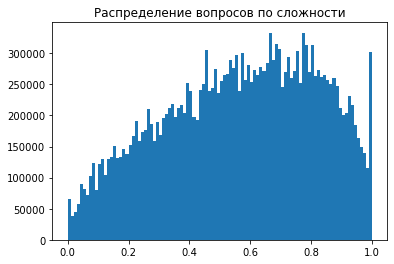

In [17]:
plt.hist(df['difficulty'],
         bins = 100,
        )
plt.title('Распределение вопросов по сложности');

Удалим игроков которые ответили меньше чем на 1000 вопросов  
Не стоит пока этого делать

In [459]:
# df = df_questions[df_questions.groupby('player_id')['answer'].transform(len) >= 1000]

### Задание 2
Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:

In [18]:
df.head()

,question_id,year,team_id,team_position,player_id,player_rating,answer,player_position,difficulty
0,0,2019,3730,1.5,117,"{'id': 117, 'name': 'Марина', 'patronymic': 'Г...",1,1176.0,0.325116
1,0,2019,3730,1.5,87865,"{'id': 87865, 'name': 'Константин', 'patronymi...",1,1028.0,0.325116
2,0,2019,3730,1.5,30672,"{'id': 30672, 'name': 'Татьяна', 'patronymic':...",1,1291.0,0.325116
3,0,2019,3730,1.5,35442,"{'id': 35442, 'name': 'Айрат', 'patronymic': '...",1,1521.0,0.325116
4,0,2019,3730,1.5,63465,"{'id': 63465, 'name': 'Александр', 'patronymic...",1,2050.0,0.325116


In [33]:
(df['difficulty'] / df['difficulty'].shape[0]).sum()

0.5650430048110444

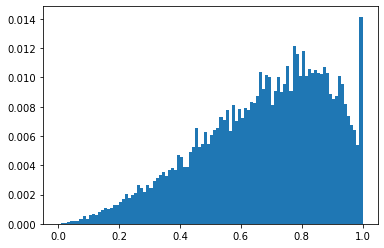

In [36]:
w_dist = plt.hist(df['difficulty'],
                     bins = 100,
                     weights=df['difficulty'] / df['difficulty'].shape[0] # Вес от сложности
                    )

In [37]:
df1000 = df[df.groupby('player_id')['answer'].transform(len) >= 1000]

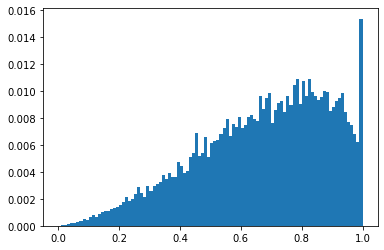

In [38]:
w_dist = plt.hist(df1000['difficulty'],
         bins = 100,
         weights=df1000['difficulty'] / df1000['difficulty'].shape[0],
        );

In [39]:
rating = {}
rating_coef = {}
players = df1000.player_id.unique()
difficulty = w_dist[1][1:].reshape(-1, 1)
for player in tqdm(players):
    log_reg = LogisticRegression()
    log_reg.fit(df1000[df1000.player_id == player].loc[:,'difficulty'].values.reshape(-1,1),
                df1000[df1000.player_id == player].loc[:,'answer'])
    rating_coef[player] = log_reg.coef_[0][0]
    rating[player] = np.dot(log_reg.predict_proba(difficulty)[:, 1], w_dist[0])

100%|██████████| 5346/5346 [02:05<00:00, 42.44it/s]


In [40]:
df1000['player_rating_calc'] = df.player_id.map(rating)

<ipython-input-40-f16d7c02ae58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1000['player_rating_calc'] = df.player_id.map(rating)


In [41]:
df1000['player_rating_calc_coef'] = df.player_id.map(rating_coef)

<ipython-input-41-2870ced5eb0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1000['player_rating_calc_coef'] = df.player_id.map(rating_coef)


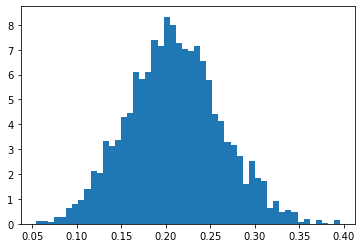

In [44]:
plt.hist(df1000.player_rating_calc,bins=50,density=True);

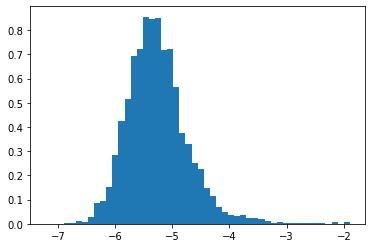

In [45]:
plt.hist(df1000.player_rating_calc_coef,bins=50,density=True); 

In [46]:
df_to_players = df1000.loc[:,['player_id', 'player_position', 'player_rating_calc', 'player_rating_calc_coef']].drop_duplicates()

In [47]:
df_players = pd.merge(df_players,
         df_to_players,
         left_on='id',
         right_on='player_id',
        )
df_players.drop('player_id',axis=1,inplace=True)

In [48]:
df_players.sort_values('player_rating_calc',ascending=False).head(30)

,id,name,patronymic,surname,player_position,player_rating_calc,player_rating_calc_coef
1047,27403,Максим,Михайлович,Руссо,5.0,0.395960,-5.569328
154,4270,Александра,Владимировна,Брутер,6.0,0.395049,-5.428943
1103,28751,Иван,Николаевич,Семушин,3.0,0.390008,-5.550281
2495,87637,Антон,Владимирович,Саксонов,158.0,0.389297,-5.373665
1068,27822,Михаил,Владимирович,Савченков,2.0,0.378418,-5.697718
1170,30270,Сергей,Леонидович,Спешков,4.0,0.374724,-5.613956
1163,30152,Артём,Сергеевич,Сорожкин,1.0,0.373385,-5.749614
1829,56647,Наталья,Евгеньевна,Горелова,349.0,0.372971,-5.380099
668,18036,Михаил,Ильич,Левандовский,8.0,0.361507,-4.535756
682,18332,Александр,Витальевич,Либер,7.0,0.360686,-5.142142


Топ 10 выгялдит более менее, топ 30 и топ 100 уже значительно хуже

### Задача 3

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:

предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;

Cилу команд будем определять как совокупность силы ее игроков. И будем расчитывать ее как вероятность того что ни один из игроков не ответил на вопрос.

в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров

In [49]:
test_df = df_tournaments[df_tournaments['dateStart'].map(lambda x: int(x[:4])) == 2020]

In [50]:
df_players.head()

,id,name,patronymic,surname,player_position,player_rating_calc,player_rating_calc_coef
0,15,Олег,Игоревич,Абарников,3255.0,0.142944,-4.978384
1,79,Саидкамол,Саидахатович,Абдуразаков,4667.0,0.182404,-4.437197
2,80,Виктор,Александрович,Абдураманов,1986.0,0.247050,-5.411615
3,82,Владимир,Юрьевич,Абдурахманов,6606.0,0.147442,-5.440365
4,117,Марина,Германовна,Аботурова,1176.0,0.240380,-6.103618


In [62]:
id_players = set(df_players['id'].unique())
spearman_corr = []
kendall_corr =[]
team_team = {}
for t_id in tqdm(test_df['id'].values):
    if results[t_id]:
        if 'position' in results[t_id][0]:
            team_position = []
            predicted_team_position = []
            for team in results[t_id]:
                team_position.append(team['position'])
                members = []
                team_prob = 1
                for player in team['teamMembers']:
                    members.append(player['player']['id'])
                #Предположение о том что у игроков команде примерно одинаковый уровень
                mean_team_rating = df_players[df_players.id.isin(members)].player_rating_calc.mean()
                # Если мы расчитали рейтинг игрока берем его, если нет берем средний по команде
                for player in members:       
                    if player in id_players:
                        player_prob = df_players[df_players['id'] == player].player_rating_calc.values[0]
                    else:
                        player_prob = mean_team_rating
                team_prob *= (1 - player_prob)
                predicted_team_position.append(1 - team_prob)
                team_team[team['team']['id']] = 1 - team_prob
            spearman = np.abs(sps.spearmanr(np.array(predicted_team_position), np.array(team_position)))
            kendall = np.abs(sps.kendalltau(np.array(predicted_team_position), np.array(team_position)))       
            spearman_corr.append(spearman[0])
            kendall_corr.append(kendall[0])
            
spearman_corr = [i for i in spearman_corr if ~np.isnan(i)]
kendall_corr = [i for i in kendall_corr if ~np.isnan(i)]

 24%|██▍       | 102/418 [00:18<00:54,  5.83it/s]/Users/out-opalev1-rs/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
 56%|█████▋    | 236/418 [00:30<00:22,  8.12it/s]/Users/out-opalev1-rs/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
100%|██████████| 418/418 [00:33<00:00, 12.66it/s]


In [64]:
print('Корреляция Спирмена, усредненная: {:.4}'.format(np.mean(spearman_corr)))
print('Корреляция Кендалла, усредненная: {:.4}'.format(np.mean(kendall_corr)))

Корреляция Спирмена, усредненная: 0.7516
Корреляция Кендалла, усредненная: 0.6317


### Задача 4

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:  
предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;  
разработайте EM-схему для обучения этой модели, реализуйте её в коде;  
обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


Скрытные переменые - вероятность команды ответить, вероятность ответа игрока(список?)

Не осилил